<a href="https://colab.research.google.com/github/konstanzer/brainpickings.org/blob/main/brain_pickings_NLP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [426]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.1 Make classes based on date
The reason for doing this classification may be to distinguish Maria's early and late writing style. Summer (June 21) 2014 is my dividing line. This date divides the total word count more or less evenly (I figured this date out in EDA.)

In [429]:
path = "data/articles.csv'"
url = "https://raw.githubusercontent.com/konstanzer/brainpickings.org/main/data/articles.csv"
df = pd.read_csv(url, index_col='index')
df.date = pd.to_datetime(df.date)

#Make the target early vs. late period
df["early"]=1
df.early[(df.date>'2014-06-20')]=0

#I drop the split year where half of all errors were originally
df = df[(df.date.dt.year != 2014)]

#I drop stub articles (under 290 words) to even un the classes
early, late = df.early.value_counts()[1], df.early.value_counts()[0]
early_stubs = np.argsort(df.words[df.early==1].values)[:early-late]
early_stubs += 1 #original index started at 1!
df=df.drop(index=early_stubs)
df=df.reset_index(drop=True)

#the input
articles = df.title + df.content

y = df.early
y.value_counts()

1    1927
0    1927
Name: early, dtype: int64

### 1.2 Feature Extraction with Tf-Idf vectorizer

* INTERPRETABILITY is the GOAL for this model not accuracy (you would never need to guess the date of an article!)
* USE MORE n-grams!
* if 2014 has all the errors, LEAVE IT OUT
* split then vectorize, not for feature interpretability but for reporting accurate metrics
* HOW tfidf works: it rewards a word for being loyal to a document and then punishes it if it has been sleeping around with all the documents


### 1.3 Modeling
#### 1.3.1 Logistic regression used for tuning min_df and max_df in tfidf vectorizer

In [444]:
#do this before vectorizer
X_train, X_test, y_train, y_test = train_test_split(articles, y, test_size=0.2, stratify=y, random_state=36)

stop_words = list(stopwords.words('english'))

#chose following based on crossval scores
tfidf = TfidfVectorizer(min_df=.04, max_df=.75, stop_words=stop_words, ngram_range=(1,2))
X_train = tfidf.fit_transform(X_train)
X_train = StandardScaler().fit_transform(X_train.todense())

In [445]:
lr = LogisticRegression().fit(X_train, y_train.ravel())
scores = cross_val_score(estimator=lr, X=X_train, y=y_train)
"%0.3f accuracy with std of %0.2f" % (scores.mean(), scores.std())

'0.940 accuracy with std of 0.01'

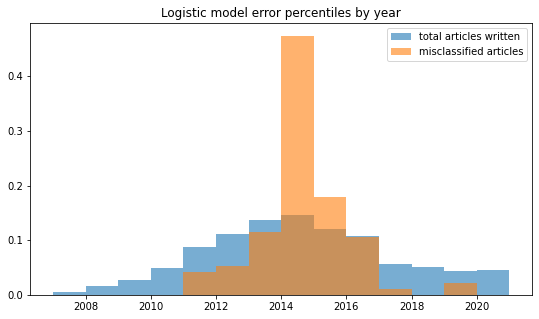

In [ ]:
#DON"T RUN THIS CELL! I made this graph from the original df with 2014
errors = np.where(np.array(y_test) != preds)[0]
X_errors = X_test[errors]
errors_ix=[]
for ix, x1 in enumerate(X):
    for x2 in X_errors:
        if np.array_equal(x1,x2):
            errors_ix.append(ix)
#yeah! errorframe
error_df = df.iloc[errors_ix]

f,ax = plt.subplots(figsize=(9,5))
ax.hist(df.date.dt.year, alpha=.6, density=True, bins=14, label="total articles written")
ax.hist(error_df.date.dt.year, alpha=.6, density=True, bins=9, label="misclassified articles")
ax.set_title("Logistic model error percentiles by year")
ax.legend();

Had this result been anything else, I'd suspect foul play. The model is right 91 percent of the time almost out-of-the-box. I divided the corpus in half rather arbitrarily. Nothing changed suddenly to make Popova a different writer (that I know of.) Writing styles change gradually and the model appears to truly be capturing this shift very well.

## Forest used for superior feature interpretability
It turns out classifying old or new without the split year was a trivial task for these machine learning models. Logistic regression and even a decision tree scored perfect accuracy (tree was cost complexity pruned to depth 26/alpha=.002 where a higher alpha indicates higher leaf purity and fewer nodes.) This isn't that surprising considering the training data contained ~3 million words to classify ~1900 articles into only two classes. But since accuracy was never in question, the goal here was to simplify the model and pull out interesting features to split the trees on. As I did so, adding one stop word at a time, I hit on the idea of using bigrams to extract people's names. This process ended in a list of 15 proper names and 3 categories (love letters, children's books, and picture books) which I considered a good stopping point. Even with this handful of bigrams, the test data was still predicted with 88 percent accuracy (f1 score .89).

Partial dependency plots showed about a dozen good classifiers for new articles but only few good classifiers for older articles. This is consistent with what I saw in the confusion matrix. When the model predicted late period, it was extremely accurate (recall .93) but when it predicted early period it was less accurate (precison .85). But wait...the model had more miscadssifications of newer articles, so did I say that correctly?

In [446]:
#do this before vectorizer
X_train, X_test, y_train, y_test = train_test_split(articles, y, test_size=0.2, stratify=y, random_state=36)

stop_words = list(stopwords.words('english')) + ['public', 'complement', 'calls', 'human', 'available', 'century', 'new', 'particular', 'really',
               'makes', 'first', 'something', 'around', 'even', 'would', 'us', 'two', 'five', 'one', 'york', 'books',
               'later', 'long', 'work', 'little', 'brain', 'states', 'life', 'black', 'click', 'also', 'day', 'letters',
               'art', 'prize', 'deal', 'human', 'calls', 'ursula', 'parts', 'year', 'years', 'process', 'mind']

#chose metrics based on crossval scores
tfidf = TfidfVectorizer(min_df=.04, max_df=.75, stop_words=stop_words, ngram_range=(2,2))
X_train = tfidf.fit_transform(X_train)

#all of the scikit-learn transformers maintain samples' ordering
X_train

<3083x18 sparse matrix of type '<class 'numpy.float64'>'
	with 3143 stored elements in Compressed Sparse Row format>

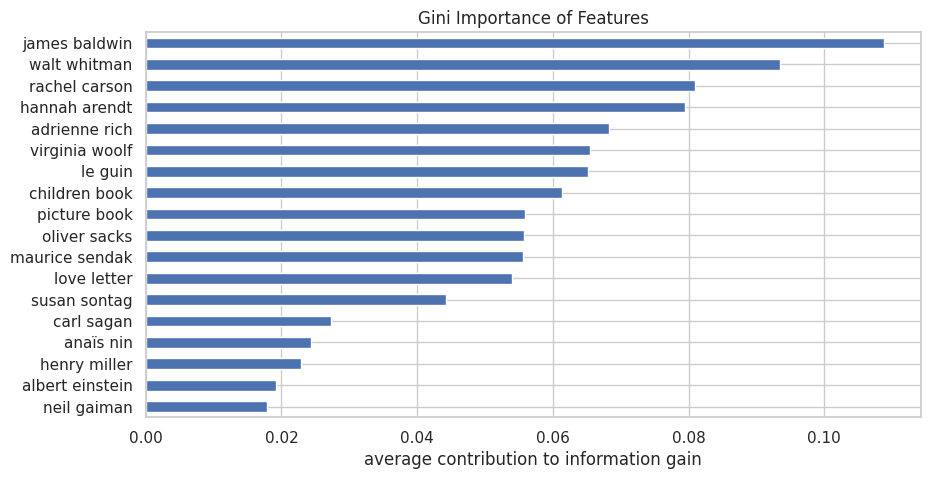

In [447]:
rf = RandomForestClassifier().fit(X_train, y_train)

feat_scores = pd.Series(rf.feature_importances_, index=tfidf.get_feature_names())
feat_scores = feat_scores.sort_values()
sns.set_theme(style="whitegrid")
ax = feat_scores.plot(kind='barh', figsize=(10,5))
ax.set_title('Gini Importance of Features')
ax.set_xlabel('average contribution to information gain');
#plt.savefig("ginibigrams.png")
#files.download("ginibigrams.png")


Accuracy: 0.88
Precision: 0.85
Recall: 0.93
F1: 0.89


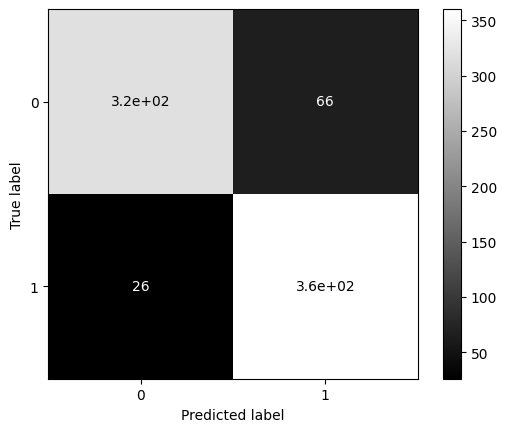

In [448]:
#X_train, X_test, y_train, y_test = train_test_split(articles, y, test_size=0.2, stratify=y, random_state=36)
X_test = tfidf.fit_transform(X_test)
rf2 = DecisionTreeClassifier().fit(X_test, y_test.ravel())
preds = rf2.predict(X_test)

plt.rcdefaults()
print(f"Accuracy: {round(rf2.score(X_test, y_test),2)}")
print(f"Precision: {round(metrics.precision_score(y_test, preds),2)}")
print(f"Recall: {round(metrics.recall_score(y_test, preds),2)}")
print(f"F1: {round(metrics.f1_score(y_test, preds),2)}")
metrics.plot_confusion_matrix(rf2, X_test, y_test, cmap="gray");
#plt.savefig("matrixtree.png")
#files.download("matrixtree.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

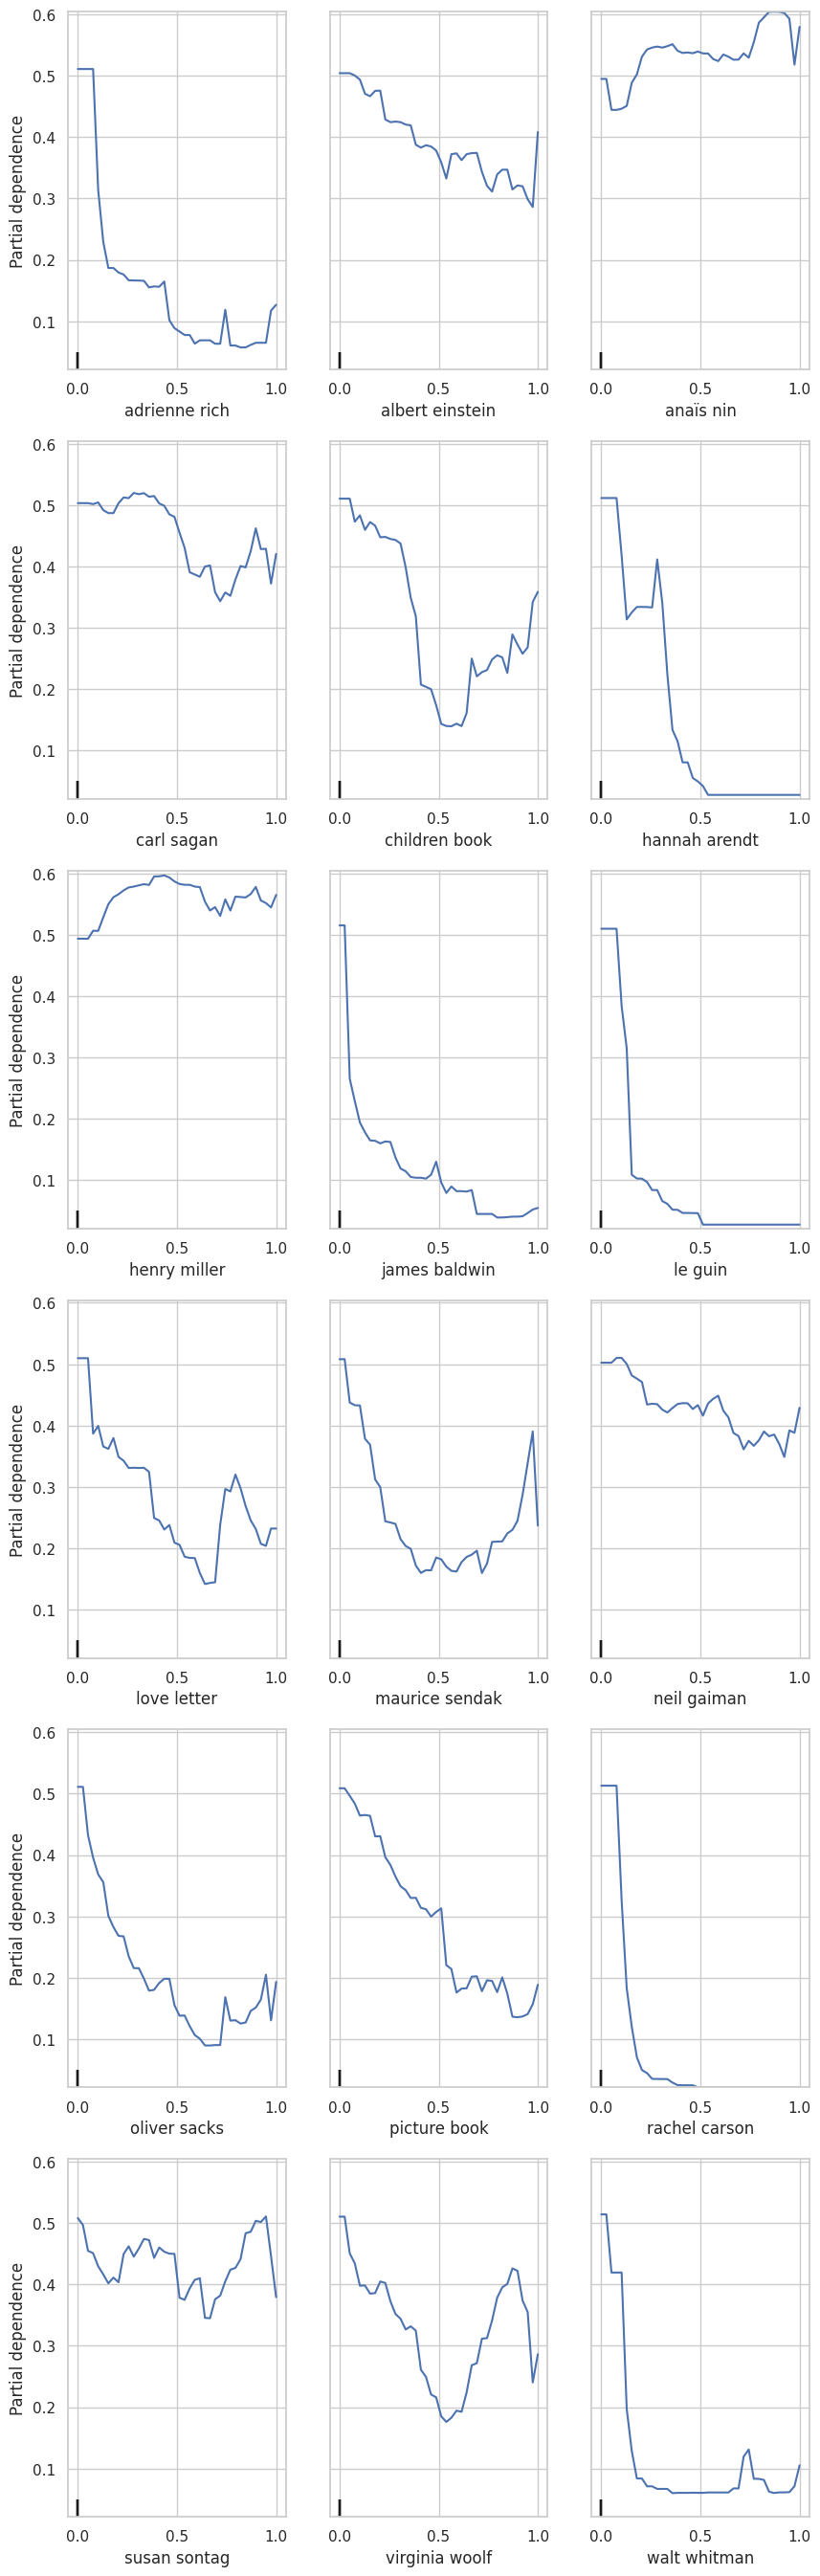

In [419]:

#pd = predicted probability of class 1, x-axis is tfidf s
fig, ax = plt.subplots(figsize=(10,34))
plot_partial_dependence(rf, X_train.A, features=list(range(18)),
                        feature_names=tfidf.get_feature_names(),
                        target=1, ax=ax, grid_resolution=40, percentiles=(0, 1));
plt.savefig("ppd.png")
files.download("ppd.png")

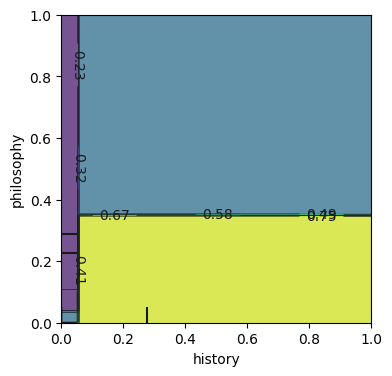

In [ ]:

#yellow high (class 1), purple low (class 0), blue in the middle
fig, ax = plt.subplots(figsize=(4,4))
plot_partial_dependence(dt, X_train.A, features=[(301,525)],
                        feature_names=tfidf.get_feature_names(),
                        target=1, ax=ax, n_jobs=3, grid_resolution=100, percentiles=(0, 1));

###...same thing for tags

In [449]:
df.tags = df.tags.str.replace(",", "")
tags = df.tags

In [471]:
X_train, X_test, y_train, y_test = train_test_split(tags, y, test_size=0.2, stratify=y, random_state=36)

stop_words = list(stopwords.words('english')) + ['writing']

#chose following based on crossval scores for tags this time
tfidf = TfidfVectorizer(min_df=2, max_df=.5, token_pattern=r"(?u)\S\S+", stop_words=stop_words, ngram_range=(1,1))
X_train = tfidf.fit_transform(X_train)
X_train = StandardScaler().fit_transform(X_train.todense())

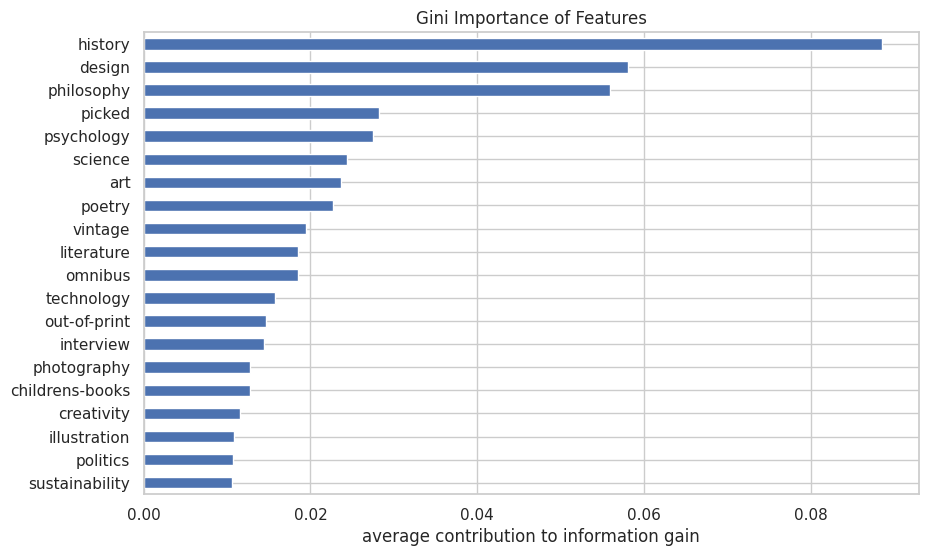

In [474]:
rf = RandomForestClassifier().fit(X_train, y_train)

feat_scores = pd.Series(rf.feature_importances_, index=tfidf.get_feature_names())
feat_scores = feat_scores.sort_values()
sns.set_theme(style="whitegrid")
ax = feat_scores[-20:].plot(kind='barh', figsize=(10,6))
ax.set_title('Gini Importance of Features')
ax.set_xlabel('average contribution to information gain');
#plt.savefig("ginibigrams.png")
#files.download("ginibigrams.png")

Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1: 0.98


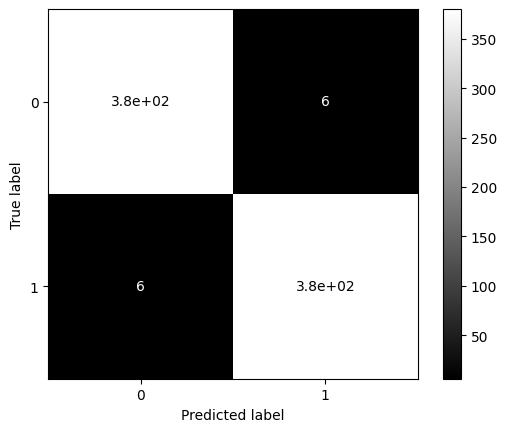

In [475]:
#X_train, X_test, y_train, y_test = train_test_split(articles, y, test_size=0.2, stratify=y, random_state=36)
X_test = tfidf.fit_transform(X_test)
rf2 = DecisionTreeClassifier().fit(X_test, y_test.ravel())
preds = rf2.predict(X_test)

plt.rcdefaults()
print(f"Accuracy: {round(rf2.score(X_test, y_test),2)}")
print(f"Precision: {round(metrics.precision_score(y_test, preds),2)}")
print(f"Recall: {round(metrics.recall_score(y_test, preds),2)}")
print(f"F1: {round(metrics.f1_score(y_test, preds),2)}")
metrics.plot_confusion_matrix(rf2, X_test, y_test, cmap="gray");
#plt.savefig("matrixtree.png")
#files.download("matrixtree.png")

most common words...
* life       15044
* world      10759
* time       10645
* art        10007
* love          9940
* human         8346
* book          7827
* people       7814
* work         7214
* science      5883
* mind              4762
* creative          4700
